## SWE spherical FVM triangular mesh

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib.animation import FuncAnimation
from matplotlib.animation import PillowWriter
import matplotlib.cm as cm
import matplotlib.colors as mcolors 

from scipy.io import loadmat

import time

from itertools import product, combinations

## Generate mesh

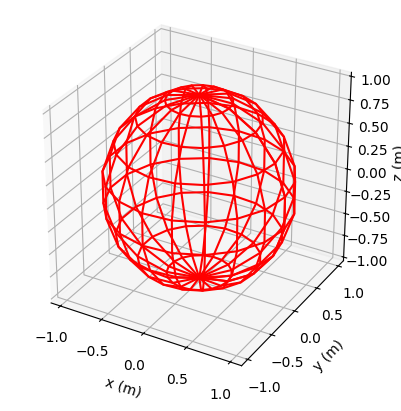

In [3]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_aspect("equal")

# draw sphere
u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
x = np.cos(u)*np.sin(v)
y = np.sin(u)*np.sin(v)
z = np.cos(v)
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_zlabel('z (m)')
ax.plot_wireframe(x, y, z, color="r")

plt.show()

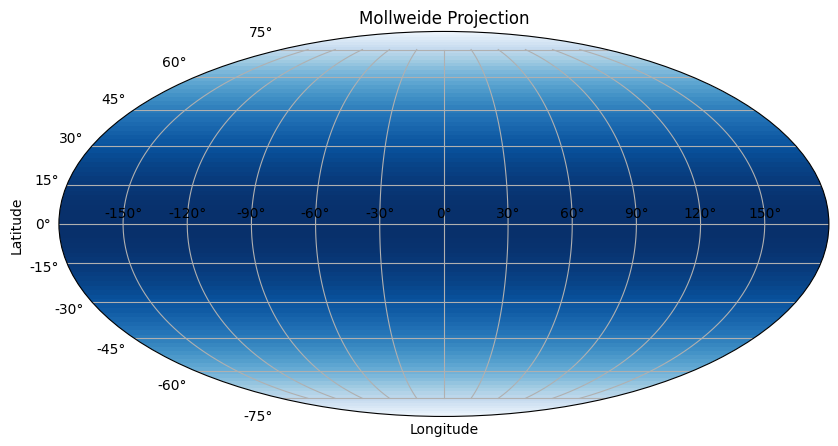

In [4]:
# Create grid of latitude (phi) and longitude (theta)
phi, theta = np.mgrid[-np.pi/2:np.pi/2:100j, 0:2*np.pi:200j]  # phi: latitude, theta: longitude

# Convert to cartesian coordinates (optional, for comparison with 3D)
x = np.sin(phi) * np.cos(theta)
y = np.sin(phi) * np.sin(theta)
z = np.cos(phi)

# Map to Mollweide projection
#longitude = theta # Keep range
longitude = theta - np.pi  # Shift range to [-π, π]
#latitude = phi - np.pi / 2  # Shift range to [-π/2, π/2]
latitude = phi

# Plot the Mollweide projection
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111, projection="mollweide")

# Convert latitude and longitude to radians for Mollweide
ax.pcolormesh(longitude, latitude, z, shading='auto', cmap='Blues')  # Color by z-values
ax.grid(True)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Mollweide Projection")
plt.show()



### Functions

In [39]:
def randomly_rotate(points):
    """
    Apply a random rotation to a set of 3D points.
    """
    random_rotation_matrix = np.linalg.qr(np.random.randn(3, 3))[0]
    return np.dot(random_rotation_matrix, points)

def get_icosahedral_mesh():
    """
    Generate an icosahedral mesh.
    Returns:
        P (numpy.ndarray): 3x12 array of vertex positions.
        tri (numpy.ndarray): 20x3 array of triangle indices.
    """
    phi = (1 + np.sqrt(5)) / 2
    P = np.array([
        [-1,  phi,  0],
        [ 1,  phi,  0],
        [-1, -phi,  0],
        [ 1, -phi,  0],
        [ 0, -1,  phi],
        [ 0,  1,  phi],
        [ 0, -1, -phi],
        [ 0,  1, -phi],
        [ phi,  0, -1],
        [ phi,  0,  1],
        [-phi,  0, -1],
        [-phi,  0,  1],
    ]).T

    # Normalize vertices to lie on the unit sphere
    P = P / np.linalg.norm(P, axis=0)

    # Center the vertices around the origin
    P = P - np.mean(P, axis=1, keepdims=True)

    # Apply a random rotation
    P = randomly_rotate(P)

    tri = np.array([
        [1, 12, 6],
        [1, 6, 2],
        [1, 2, 8],
        [1, 8, 11],
        [1, 11, 12],
        [2, 6, 10],
        [6, 12, 5],
        [12, 11, 3],
        [11, 8, 7],
        [8, 2, 9],
        [4, 10, 5],
        [4, 5, 3],
        [4, 3, 7],
        [4, 7, 9],
        [4, 9, 10],
        [5, 10, 6],
        [3, 5, 12],
        [7, 3, 11],
        [9, 7, 8],
        [10, 9, 2]
    ]) - 1  # Convert 1-based indexing to 0-based

    return P, tri


def plot_icosahedral_mesh(P, tri):
    """
    Plot an icosahedral mesh using Matplotlib.
    Args:
        P (numpy.ndarray): 3x12 array of vertex positions.
        tri (numpy.ndarray): 20x3 array of triangle indices.
    """
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Create the trisurf plot
    ax.plot_trisurf(P[0, :], P[1, :], P[2, :], triangles=tri, edgecolor='k', linewidth=0.5, alpha=0.8)

    # Set the aspect ratio to be equal
    ax.set_box_aspect([1, 1, 1])  # Equal aspect ratio for all axes

    # Set axis limits for better visualization
    limit = 1.2
    ax.set_xlim([-limit, limit])
    ax.set_ylim([-limit, limit])
    ax.set_zlim([-limit, limit])

    # Turn off the grid and axis for a cleaner look (optional)
    ax.grid(False)
    ax.axis('off')

    plt.show()

def refine_mesh(Pin, triin):
    """
    Refine a triangular mesh by subdividing each triangle into smaller triangles.
    Args:
        Pin (numpy.ndarray): 3xN array of vertex positions.
        triin (numpy.ndarray): Mx3 array of triangle indices.

    Returns:
        P (numpy.ndarray): Refined 3xN array of vertex positions.
        tri (numpy.ndarray): Refined Mx3 array of triangle indices.
    """
    N = Pin.shape[1]  # Number of vertices in the original mesh

    # Step 1: Generate all edges for each triangle
    edges_1 = triin[:, [0, 1]]  # Edges between vertices 0 and 1
    edges_2 = triin[:, [1, 2]]  # Edges between vertices 1 and 2
    edges_3 = triin[:, [2, 0]]  # Edges between vertices 2 and 0

    # Combine all edges and sort each edge to ensure consistent order
    edges = np.vstack([edges_1, edges_2, edges_3])
    edges_sorted = np.sort(edges, axis=1)

    # Step 2: Find unique edges and their indices
    edges_unique, unique_indices = np.unique(edges_sorted, axis=0, return_inverse=True)

    # Step 3: Create new vertices at the midpoints of unique edges
    Pnew = (Pin[:, edges_unique[:, 0]] + Pin[:, edges_unique[:, 1]]) / 2
    Pnew = Pnew / np.linalg.norm(Pnew, axis=0, keepdims=True)  # Normalize to unit sphere

    # Step 4: Map triangle edges to new vertices
    idx1 = unique_indices[:len(triin)]            # Indices for edges_1
    idx2 = unique_indices[len(triin):2*len(triin)]  # Indices for edges_2
    idx3 = unique_indices[2*len(triin):]          # Indices for edges_3

    # Step 5: Generate new triangles
    tri = np.vstack([
        np.column_stack([triin[:, 0], N + idx1, N + idx3]),
        np.column_stack([triin[:, 1], N + idx2, N + idx1]),
        np.column_stack([triin[:, 2], N + idx3, N + idx2]),
        np.column_stack([N + idx1, N + idx2, N + idx3])
    ])

    # Step 6: Combine original and new vertices
    P = np.hstack([Pin, Pnew])

    return P, tri


## Icosahedral

P shape: (3, 12), tri shape: (20, 3)


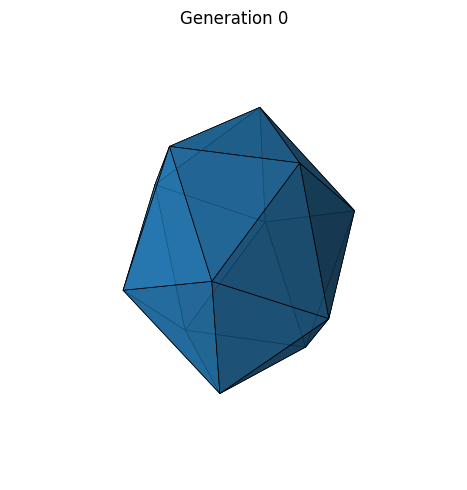

In [143]:
# Generate the initial icosahedral mesh
P, tri = get_icosahedral_mesh()

# Prepare for refinement generations
generations = 1
meshes = [(P, tri)]  # Store the meshes for each generation

# Generate refined meshes for each generation
for _ in range(generations):
    print(f'P shape: {P.shape}, tri shape: {tri.shape}')
    P, tri = refine_mesh(P, tri)
    meshes.append((P, tri))

# Create subplots to visualize the first three generations
fig = plt.figure(figsize=(15, 5))
for i in range(generations):
    ax = fig.add_subplot(1, generations, i + 1, projection='3d')
    P, tri = meshes[i]
    ax.plot_trisurf(
        P[0, :], P[1, :], P[2, :],
        triangles=tri,
        edgecolor='k',
        linewidth=0.5,
        alpha=0.8
    )
    ax.set_title(f"Generation {i}")
    ax.set_box_aspect([1, 1, 1])  # Equal aspect ratio for 3D
    ax.axis('off')  # Turn off axis for clarity

# Display the subplots
plt.tight_layout()
#plt.savefig('Plots/icosahedral_mesh_refinement.pdf', format='pdf')
plt.show()

In [163]:
tri.shape

(20, 3)

In [ ]:
K

In [184]:
def tiConnect(EToV, P):
    _, Nnodes = P.shape
    K, Nfaces = EToV.shape

    # Create list of all faces (edges) from the triangles
    fnodes = []
    for i in range(K):
        for j in range(Nfaces):
            if j == Nfaces - 1:
                fnodes.append([EToV[i, j], EToV[i, 0]])  # Create the last edge for a triangle
            else:
                fnodes.append([EToV[i, j], EToV[i, j +1]])

    # Convert to numpy array and sort faces to ensure consistent ordering
    fnodes = np.array(fnodes)  # Shape (60, 2) for 60 edges
    fnodes = np.sort(fnodes, axis=1)

    # Initialize element-to-element (EToE) and element-to-face (EToF) connectivity tables
    EToE = np.tile(np.arange(K), (Nfaces, 1)).T  # Default: each triangle is connected to itself
    EToF = np.tile(np.arange(Nfaces), (K, 1))  # Default: each face is indexed as 1, 2, 3 for each triangle

    # Generate unique face IDs based on sorted vertex indices
    face_ids = fnodes[:, 0] * Nnodes + fnodes[:, 1] + 1
    print('here')
    print(face_ids.shape)
    print(K)
    print(Nfaces)
    print((Nfaces*K+1))
    spNodeToNode = np.column_stack([face_ids, np.tile(np.arange(1, Nfaces * K + 1), (K, 1)).flatten(), EToE.flatten(), EToF.flatten()])

    # Sort by global face ID
    sorted_faces = spNodeToNode[np.argsort(spNodeToNode[:, 0])]

    # Find matching faces (shared edges)
    indices = np.where(sorted_faces[:-1, 0] == sorted_faces[1:, 0])[0]
    matchL = sorted_faces[indices, :]
    matchR = sorted_faces[indices + 1, :]

    # Insert matches into the connectivity tables
    for match_left, match_right in zip(matchL, matchR):
        EToE[match_left[1] - 1] = match_right[2]
        EToF[match_left[1] - 1] = match_right[3]

    return EToE, EToF


In [185]:
EToE, EToF = tiConnect(tri, P)

#fnodes.append([EToV[j, i], EToV[j + 1, i]])



here
(60,)
20
3
61


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 60 and the array at index 1 has size 1200